# **Books network and Recommendation System**
The following notebook contains the code to create a network of books using users' ratings on Goodreads. The graph is then analysed and used to train a recommendation system based on Node2Vec.
The data can be found on Kaggle: https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m/data

In [1]:
!pip install node2vec
!pip install python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from prettytable import PrettyTable
import community
import community.community_louvain as louvain
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF
from node2vec import Node2Vec

**Loading Datasets and Preprocessing**

In [4]:
# importing and concatenating users ratings
file_paths = ["/content/drive/MyDrive/archive (16)/user_rating_0_to_1000.csv", "/content/drive/MyDrive/archive (16)/user_rating_1000_to_2000.csv", "/content/drive/MyDrive/archive (16)/user_rating_2000_to_3000.csv",
             "/content/drive/MyDrive/archive (16)/user_rating_3000_to_4000.csv", "/content/drive/MyDrive/archive (16)/user_rating_4000_to_5000.csv",
             "/content/drive/MyDrive/archive (16)/user_rating_5000_to_6000.csv", "/content/drive/MyDrive/archive (16)/user_rating_6000_to_11000.csv"]

dataframes = [pd.read_csv(file) for file in file_paths]

usratings = pd.concat(dataframes, axis=0, ignore_index=True)

usratings.head()

,ID,Name,Rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing
2,1,Siddhartha,it was amazing
3,1,The Clock of the Long Now: Time and Responsibi...,really liked it
4,1,"Ready Player One (Ready Player One, #1)",really liked it


In [5]:
# check values for ratings
unique_values = usratings["Rating"].unique()

print('Rating:', unique_values)

Rating: ['it was amazing' 'really liked it' 'liked it' 'did not like it'
 'it was ok' "This user doesn't have any rating"]


In [6]:
# converte ratings in numbers

rating_mapping = {"it was amazing": 5, "really liked it": 4, "liked it": 3, "did not like it": 2, 'it was ok':1, "This user doesn't have any rating": 0}

for index, value in usratings["Rating"].items():
    if value in rating_mapping:
        usratings.at[index, "Rating"] = rating_mapping[value]

# drop users without ratings
usratings = usratings.loc[usratings['Rating'] != 0]

In [7]:
# import and concatenate books id
file_paths_2 = ["/content/drive/MyDrive/archive (16)/book1-100k.csv", "/content/drive/MyDrive/archive (16)/book100k-200k.csv", "/content/drive/MyDrive/archive (16)/book200k-300k.csv",
              "/content/drive/MyDrive/archive (16)/book300k-400k.csv", "/content/drive/MyDrive/archive (16)/book400k-500k.csv",
             "/content/drive/MyDrive/archive (16)/book500k-600k.csv", "/content/drive/MyDrive/archive (16)/book600k-700k.csv", "/content/drive/MyDrive/archive (16)/book700k-800k.csv",
             "/content/drive/MyDrive/archive (16)/book2000k-3000k.csv", "/content/drive/MyDrive/archive (16)/book3000k-4000k.csv","/content/drive/MyDrive/archive (16)/book4000k-5000k.csv"]

dataframes_2 = [pd.read_csv(file) for file in file_paths_2]

databooks = pd.concat(dataframes_2, axis=0, ignore_index=True)
databooks.tail()

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,Language,Authors,Rating,RatingDist2,RatingDist5,ISBN,RatingDist3,Description,Count of text reviews,PagesNumber
1380352,4846443,About International Trade,1:0,NaN,4:0,total:0,12,31,Dart Press,0,...,NaN,Nana Haines,0.0,2:0,5:0,187782500X,3:0,NaN,NaN,90.0
1380353,4846447,International and Global Marketing: Concepts a...,1:0,NaN,4:0,total:1,1,1,Irwin/McGraw-Hill,0,...,NaN,Taylor W. Meloan,3.0,2:0,5:0,0256218943,3:1,This text is a combination of 32 readings and ...,NaN,439.0
1380354,4846448,The Best of Vincent Mulchrone,1:0,NaN,4:0,total:0,5,23,Revel Barker,0,...,NaN,Vincent Mulchrone,0.0,2:0,5:0,0955823811,3:0,Throughout his working life Vincent Mulchrone ...,NaN,120.0
1380355,4846449,Forgive Us Our Press Passes,1:0,NaN,4:4,total:10,2,14,Revel Barker,1,...,NaN,Ian Skidmore,3.8,2:0,5:2,0955823803,3:4,"Journalist, broadcaster and author IAN SKIDMOR...",NaN,232.0
1380356,4846451,A Fractography Atlas Of Casting Alloys,1:0,NaN,4:1,total:1,1,1,Battelle Press,0,...,NaN,Gordon W. Powell,4.0,2:0,5:0,0935470670,3:0,NaN,NaN,28.0


In [8]:
databooks = databooks[['Id', 'Name']]
databooks = databooks.rename(columns={'Id': 'id_book'})
databooks = databooks.drop_duplicates(subset='Name', keep='first')
books_to_remove = ['Cien años de soledad', 'Crónica de una muerte anunciada', 'El amor en los tiempos del cólera']
databooks = databooks[~databooks['Name'].isin(books_to_remove)]
databooks.tail()

,id_book,Name
1380352,4846443,About International Trade
1380353,4846447,International and Global Marketing: Concepts a...
1380354,4846448,The Best of Vincent Mulchrone
1380355,4846449,Forgive Us Our Press Passes
1380356,4846451,A Fractography Atlas Of Casting Alloys


In [9]:
# join the two datasets
data = pd.merge(usratings, databooks, on='Name', how='left')
data = data.drop_duplicates(subset=['ID', 'Name'], keep='first')
data.tail()

,ID,Name,Rating,id_book
357826,10978,The Foundation: A Great American Secret: How P...,3,46642.0
357827,10986,Cosette: The Sequel to Les Miserables,4,166821.0
357828,10986,J. D. Salinger's The Catcher in the Rye,5,NaN
357829,10988,Facing the Lion: Growing Up Maasai on the Afri...,3,127180.0
357830,10988,Homeless Bird,3,243229.0


In [10]:
# preprocessing
data = data.rename(columns={'ID': 'user', 'Name':'title', 'Rating': 'rating'})
#data = data.drop_duplicates(subset='title', keep='first')
books_to_remove = ['Cien años de soledad', 'Crónica de una muerte anunciada', 'El amor en los tiempos del cólera']
data = data[~data['title'].isin(books_to_remove)]
data = data.dropna()
data['id_book'] = data['id_book'].astype(int)

<ipython-input-10-a9de56f0306f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id_book'] = data['id_book'].astype(int)


In [11]:
books = data[['id_book', 'title']].copy()
data = data[['user', 'rating', 'id_book']]

In [12]:
# only books that have been liked by the same users
data = data[data.rating >= 4]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142588 entries, 0 to 357827
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     142588 non-null  int64 
 1   rating   142588 non-null  object
 2   id_book  142588 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [13]:
data.tail()

,user,rating,id_book
357821,10978,4,251884
357823,10978,4,356824
357824,10978,4,186538
357825,10978,4,181343
357827,10986,4,166821


# **Creating the Graph**

In [14]:
# taking random sample of the dataset for computational reasons
sampled_df = data.sample(frac=0.5, random_state=42)

In [15]:
from collections import defaultdict

pairs = defaultdict(int)

In [16]:
for group in sampled_df.groupby("user"):
    user_books = list(group[1]["id_book"])
    for i in range(len(user_books)):
        for j in range(i+1, len(user_books)):
            pairs[(user_books[i], user_books[j])] += 1

In [17]:
# creating graph
G = nx.Graph()

In [18]:
for pair in pairs:
    book1, book2 = pair
    score = pairs[pair]
    if score >= 5:
        # nodes with title
        title1 = books[books.id_book == book1].title.values[0]
        title2 = books[books.id_book == book2].title.values[0]
        G.add_node(book1, title=title1)
        G.add_node(book2, title=title2)

        # add edge
        G.add_edge(book1, book2, weight=score)
print(G)

Graph with 695 nodes and 9894 edges


**Visualization**

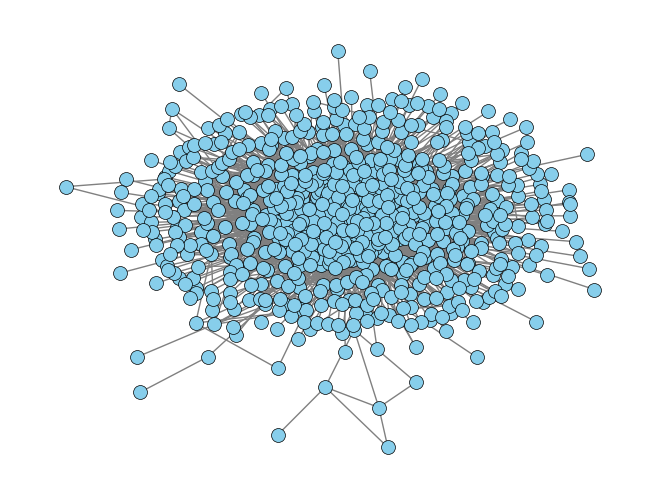

In [ ]:
# visualize the graph
pos = nx.kamada_kawai_layout(G)
#subgraph = G.edge_subgraph(list(G.edges())[:100])
#nx.draw(subgraph, pos, with_labels=False, font_size=5, node_size=700, node_color='skyblue', font_weight='bold', edge_color='gray')
nx.draw(G, pos, with_labels=False, font_size=5, node_size=100, node_color='skyblue', font_weight='bold', edge_color='gray', edgecolors='black', linewidths=0.5)

#labels = nx.get_node_attributes(G, 'title')
#nx.draw_networkx_labels(G, pos, labels, font_size=5)

plt.show()

Graph with 695 nodes and 9894 edges


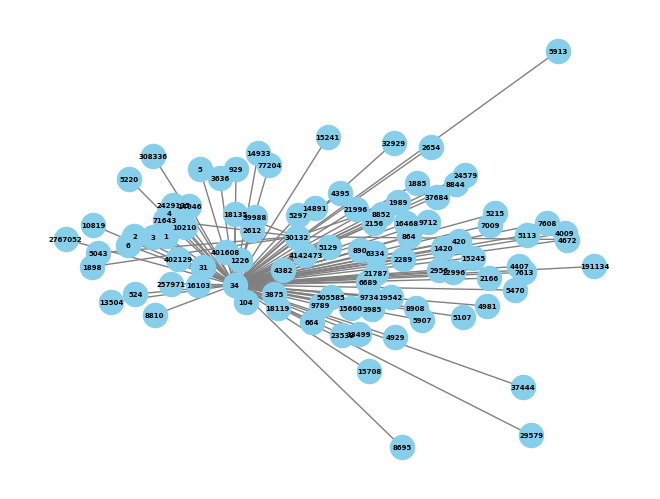

In [ ]:
print(G)
layout = nx.kamada_kawai_layout(G)
subgraph = G.edge_subgraph(list(G.edges())[:100])
nx.draw(subgraph, pos=layout, with_labels=True, font_weight='bold', node_size=300, node_color='skyblue', font_size=5, edge_color='gray')

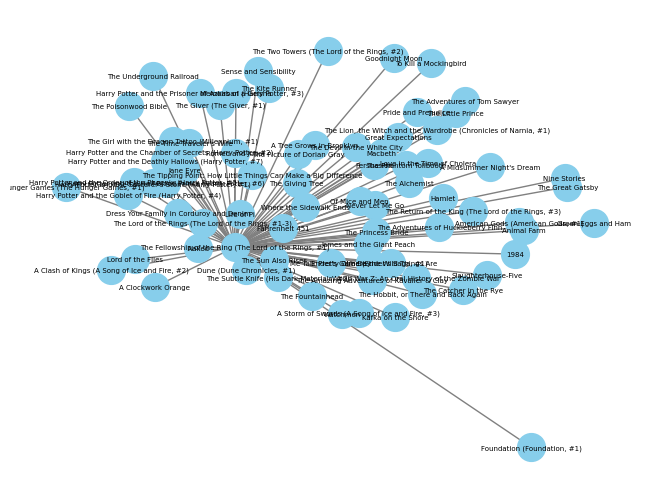

In [ ]:
subgraph = G.edge_subgraph(list(G.edges())[:75])
nx.draw(subgraph, pos, with_labels=False, font_size=5, node_size=400, node_color='skyblue', font_weight='bold', edge_color='gray')

labels = nx.get_node_attributes(subgraph, 'title')
nx.draw_networkx_labels(subgraph, pos, labels, font_size=5)

plt.show()

# **Network Analysis**

Min Degree:	1
Max Degree:	323
Mean Degree:	28.47
Standard Dev:	48.96
Median Degree:	7


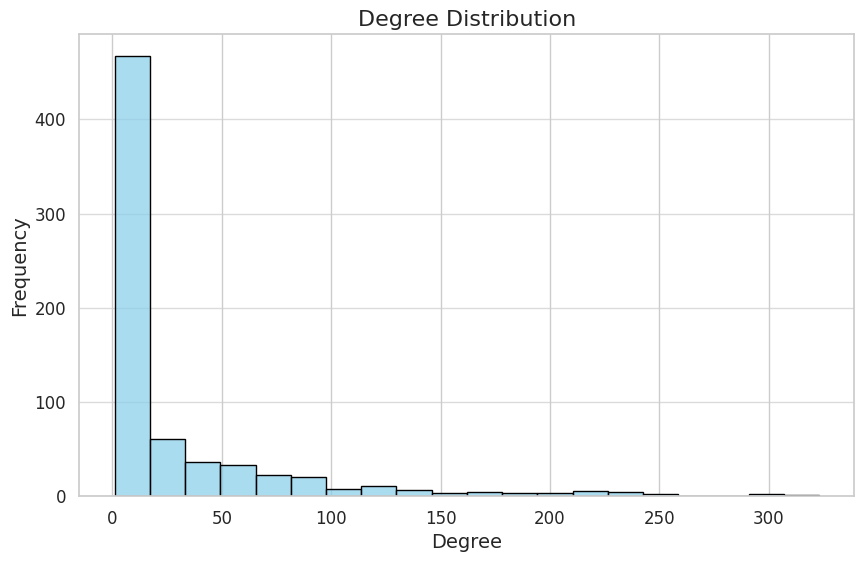

In [21]:
# Compute the degree of the graph
degrees = dict(G.degree())
degree_values = list(dict(degrees).values())

print("Min Degree:\t{}".format(np.min(degree_values)))
print("Max Degree:\t{}".format(np.max(degree_values)))
print("Mean Degree:\t{:.2f}".format(np.mean(degree_values)))
print("Standard Dev:\t{:.2f}".format(np.std(degree_values)))
print("Median Degree:\t{:.0f}".format(np.median(degree_values)))

sns.set(style="whitegrid")

# Plot the degree distribution
plt.figure(figsize=(10, 6))
sns.histplot(degree_values, bins=20, kde=False, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Degree Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.show()

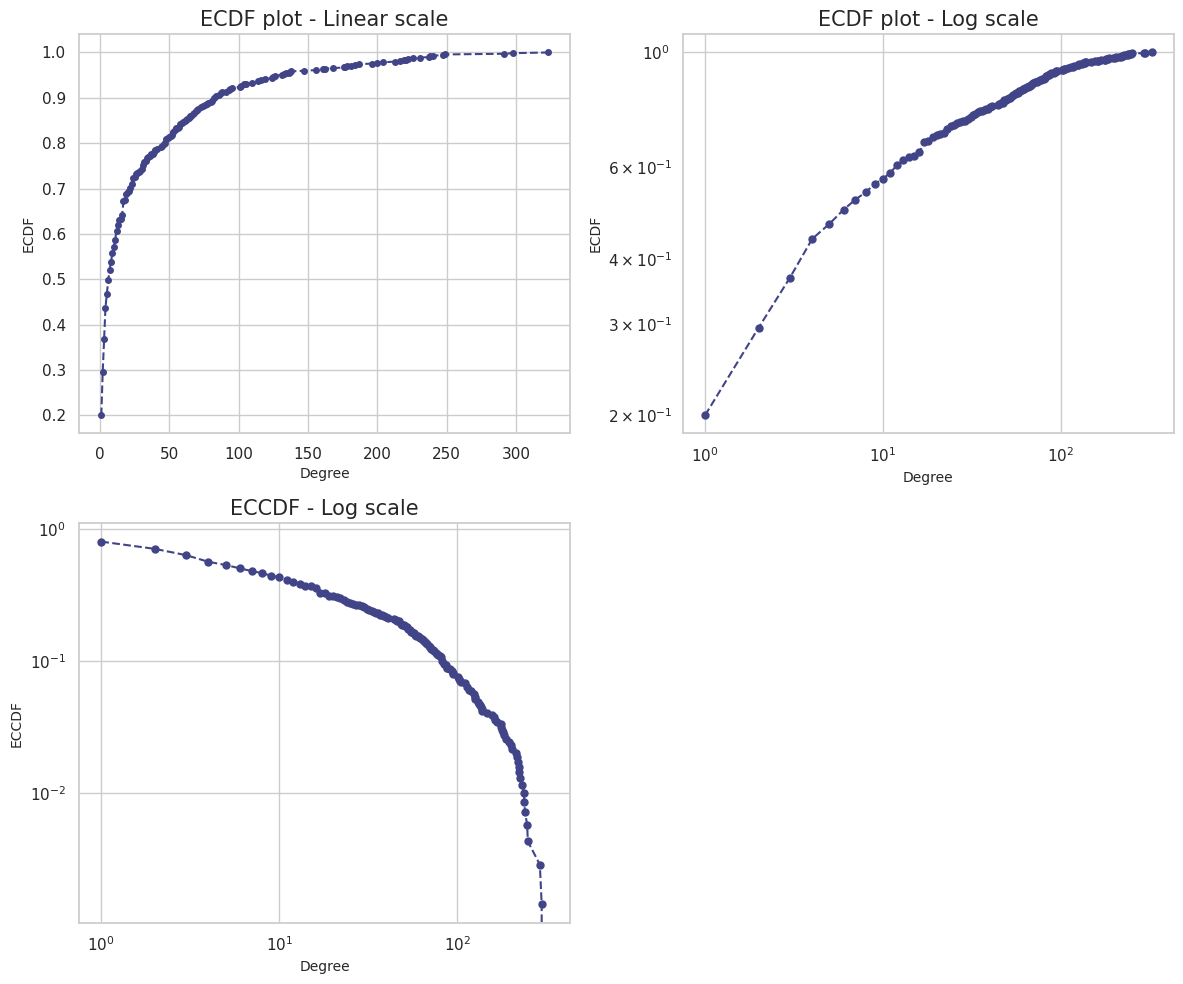

In [23]:
# Compute ECDF
cdf_function = ECDF(degree_values)
x = np.unique(degree_values)
y = cdf_function(x)
eccdf_y = 1 - cdf_function(x)

palette = sns.color_palette("viridis", n_colors=4)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot ECDF in linear scale
axs[0, 0].plot(x, y, color=palette[0], linestyle='--', marker='o', ms=4)
axs[0, 0].set_xlabel('Degree', size=10)
axs[0, 0].set_ylabel('ECDF', size=10)
axs[0, 0].set_title("ECDF plot - Linear scale", size=15)
axs[0, 0].grid(True)

# Plot ECDF in log scale
axs[0, 1].loglog(x, y, color=palette[0], linestyle='--', marker='o', ms=5)
axs[0, 1].set_xlabel('Degree', size=10)
axs[0, 1].set_ylabel('ECDF', size=10)
axs[0, 1].set_title("ECDF plot - Log scale", size=15)

# Plot ECCDF in log scale
axs[1, 0].loglog(x, eccdf_y, color=palette[0], linestyle='--', marker='o', ms=5)
axs[1, 0].set_xlabel('Degree', size=10)
axs[1, 0].set_ylabel('ECCDF', size=10)
axs[1, 0].set_title("ECCDF - Log scale", size=15)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

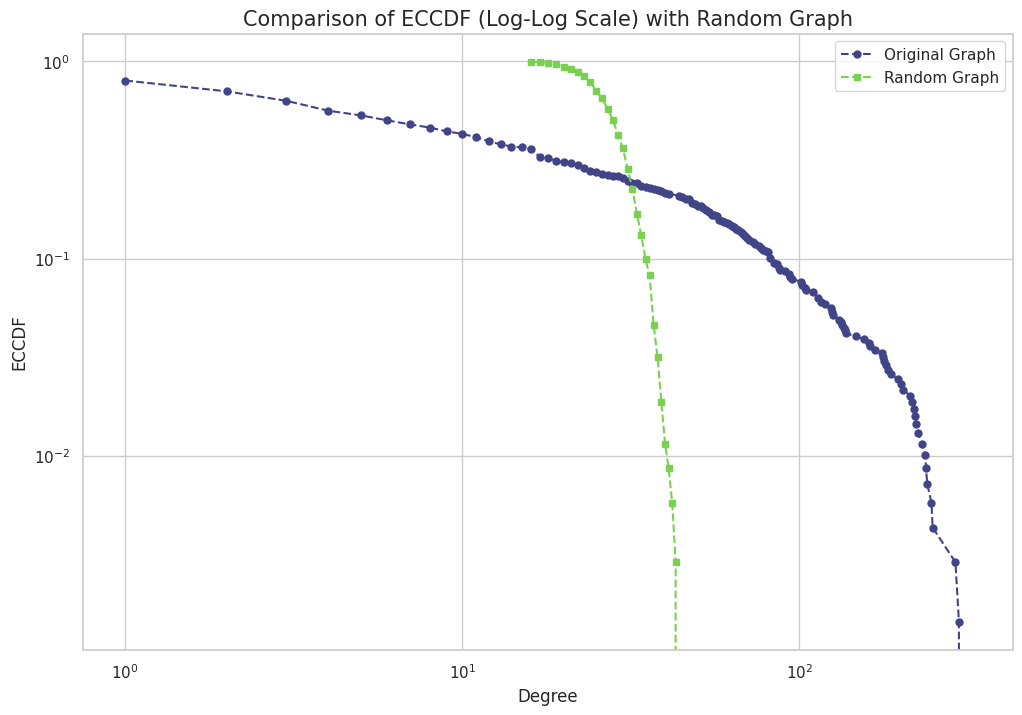

In [26]:
# Generate a random graph with the same number of nodes and approximately the same number of edges
n_nodes = len(G.nodes)
n_edges = len(G.edges)
p = n_edges / (n_nodes * (n_nodes - 1) / 2)  # Edge probability for Erdős–Rényi model

random_graph = nx.erdos_renyi_graph(n_nodes, p)

# Calculate degree and ECCDF for the random graph
random_degrees = dict(random_graph.degree())
random_degree_values = list(random_degrees.values())
random_cdf_function = ECDF(random_degree_values)
random_eccdf_y = 1 - random_cdf_function(np.unique(random_degree_values))

plt.figure(figsize=(12, 8))

# Plot ECCDF
plt.loglog(x, eccdf_y, color=palette[0], linestyle='--', marker='o', ms=5, label='Original Graph')

# Plot ECCDFfor rn
plt.loglog(np.unique(random_degree_values), random_eccdf_y, color=palette[3], linestyle='--', marker='s', ms=5, label='Random Graph')

plt.xlabel('Degree', size=12)
plt.ylabel('ECCDF', size=12)
plt.title('Comparison of ECCDF (Log-Log Scale) with Random Graph', size=15)
plt.legend()
plt.grid(True)
plt.show()

# **Centrality and Most central books**

In [19]:
# Calculate and display top 5 degree centrality
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_degree_centrality = sorted_degree_centrality[:5]
print("\nTop 5 Degree Centrality:")
for node, centrality in top_5_degree_centrality:
    title = G.nodes[node]['title']
    print(f"Book: {title}, Degree Centrality: {centrality:.4f}")

# Calculate and display top 5 betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_betweenness_centrality = sorted_betweenness_centrality[:5]
print("\nTop 5 Betweenness Centrality:")
for node, centrality in top_5_betweenness_centrality:
    title = G.nodes[node]['title']
    print(f"Book: {title}, Betweenness Centrality: {centrality:.4f}")

# Calculate and display top 5 closeness centrality
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_closeness_centrality = sorted_closeness_centrality[:5]
print("\nTop 5 Closeness Centrality:")
for node, centrality in top_5_closeness_centrality:
    title = G.nodes[node]['title']
    print(f"Book: {title}, Closeness Centrality: {centrality:.4f}")

# Calculate and display top 5 eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
top_5_eigenvector_centrality = sorted_eigenvector_centrality[:5]
print("\nTop 5 Eigenvector Centrality:")
for node, centrality in top_5_eigenvector_centrality:
    title = G.nodes[node]['title']
    print(f"Book: {title}, Eigenvector Centrality: {centrality:.4f}")


Top 5 Degree Centrality:
Book: To Kill a Mockingbird, Degree Centrality: 0.4654
Book: The Great Gatsby, Degree Centrality: 0.4294
Book: The Catcher in the Rye, Degree Centrality: 0.4193
Book: Me Talk Pretty One Day, Degree Centrality: 0.3588
Book: The Kite Runner, Degree Centrality: 0.3559

Top 5 Betweenness Centrality:
Book: To Kill a Mockingbird, Betweenness Centrality: 0.0950
Book: The Catcher in the Rye, Betweenness Centrality: 0.0833
Book: The Great Gatsby, Betweenness Centrality: 0.0769
Book: Me Talk Pretty One Day, Betweenness Centrality: 0.0518
Book: Slaughterhouse-Five, Betweenness Centrality: 0.0468

Top 5 Closeness Centrality:
Book: To Kill a Mockingbird, Closeness Centrality: 0.6333
Book: The Great Gatsby, Closeness Centrality: 0.6184
Book: The Catcher in the Rye, Closeness Centrality: 0.6145
Book: The Kite Runner, Closeness Centrality: 0.5890
Book: Me Talk Pretty One Day, Closeness Centrality: 0.5885

Top 5 Eigenvector Centrality:
Book: To Kill a Mockingbird, Eigenvector 

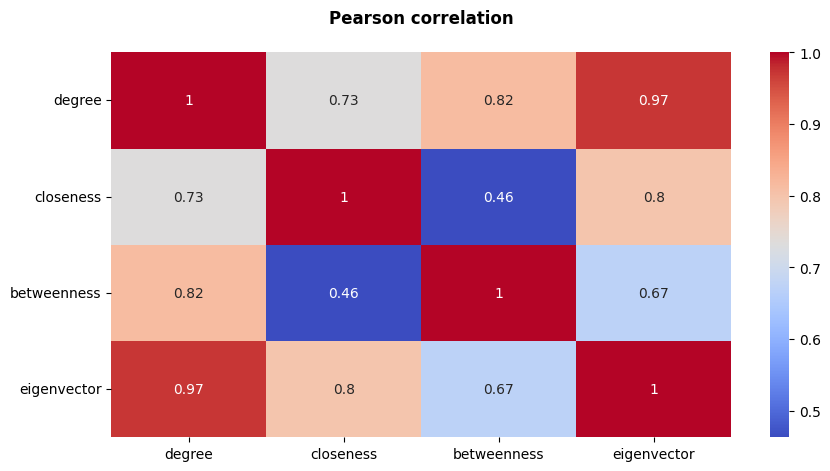

In [22]:
all_centr = [degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']

plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()


In [ ]:
degree_dict = dict(G.degree())
sorted_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

top_hubs = sorted_degrees[:5]

print("Top 5 Hubs:")
for node, degree in top_hubs:
    title = G.nodes[node]['title']
    print(f"Book: {title}, Degree: {degree}")

Top 5 Hubs:
Book: To Kill a Mockingbird, Degree: 323
Book: The Great Gatsby, Degree: 298
Book: The Catcher in the Rye, Degree: 291
Book: Me Talk Pretty One Day, Degree: 249
Book: The Kite Runner, Degree: 247


**Connected components and Clustering coefficient**

In [23]:
# Calculate connected components
connected_components = list(nx.connected_components(G))

# Display sizes of connected components
component_sizes = [len(comp) for comp in connected_components]
print(f"Number of Connected Components: {len(connected_components)}")
print(f"Sizes of Connected Components: {component_sizes}")

Number of Connected Components: 3
Sizes of Connected Components: [689, 4, 2]


In [27]:
# diameter of biggest component
largest_connected_component = max(connected_components, key=len)
component1 = G.subgraph(largest_connected_component)

diameter = nx.diameter(component1)

print(f"Diameter of the largest connected component: {diameter}")

Diameter of the largest connected component: 7


In [ ]:
component_2_nodes = list(connected_components[1])
component_2_titles = [G.nodes[node]['title'] for node in component_2_nodes]
print("Titles in Connected Component 2:")
for title in component_2_titles:
    print(title)

component_3_nodes = list(connected_components[2])
component_3_titles = [G.nodes[node]['title'] for node in component_3_nodes]
print("Titles in Connected Component 3:")
for title in component_3_titles:
    print(title)

Titles in Connected Component 2:
Seven Up (Stephanie Plum, #7)
Hot Six (Stephanie Plum, #6)
Three to Get Deadly (Stephanie Plum, #3)
High Five (Stephanie Plum, #5)
Titles in Connected Component 3:
Thud! (Discworld, #34; City Watch #7)
Monstrous Regiment (Discworld, #31; Industrial Revolution, #3)


In [30]:
# bridges
bridges = list(nx.bridges(G))

total_edges = G.number_of_edges()
percentage_bridges = (len(bridges) / total_edges) * 100

print(f"Number of bridges: {len(bridges)}")
print(f"Percentage bridges: {percentage_bridges:.2f}%")

Number of bridges: 140
Percentage bridges: 1.41%


In [26]:
# Calculate clustering coefficients
local_clustering_coefficients = nx.clustering(G)
average_local_clustering_coefficient = sum(local_clustering_coefficients.values()) / len(G)
print(f"Average Local Clustering Coefficient: {average_local_clustering_coefficient:.4f}")

global_clustering_coefficient = nx.average_clustering(G)
print(f"Global Clustering Coefficient: {global_clustering_coefficient:.4f}")

Average Local Clustering Coefficient: 0.6175
Global Clustering Coefficient: 0.6175


In [28]:
# assortativity

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Assortativity of the degree: {assortativity}")

Assortativity of the degree: -0.3830175095288611


**Louvain's Communities**

In [20]:
# Identify communities
partition = louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))

print(f"Number of communities: {num_communities}")

# size
community_sizes = Counter(partition.values())

for community_id, size in community_sizes.items():
    print(f"Community {community_id}: Size {size}")

Number of communities: 8
Community 0: Size 146
Community 1: Size 69
Community 7: Size 149
Community 3: Size 184
Community 2: Size 135
Community 4: Size 6
Community 5: Size 4
Community 6: Size 2


In [ ]:
# Display communities with book titles
communities = defaultdict(list)
for node, community_id in partition.items():
    title = G.nodes[node]['title']
    communities[community_id].append(title)

for community_id, books in communities.items():
    print(f"Community {community_id}: {books}")

Community 0: ['The Fellowship of the Ring (The Lord of the Rings, #1)', 'Harry Potter and the Deathly Hallows (Harry Potter, #7)', 'A Clash of Kings (A Song of Ice and Fire, #2)', "Ender's Game (Ender's Saga, #1)", 'The Two Towers (The Lord of the Rings, #2)', 'A Storm of Swords (A Song of Ice and Fire, #3)', 'Harry Potter and the Goblet of Fire (Harry Potter, #4)', 'The Subtle Knife (His Dark Materials, #2)', 'The Remains of the Day', "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", 'Snow Crash', "Hatchet (Brian's Saga, #1)", 'A Feast for Crows (A Song of Ice and Fire, #4)', 'Neverwhere (London Below, #1)', 'Stardust', 'The Amber Spyglass (His Dark Materials, #3)', "Speaker for the Dead (Ender's Saga, #2)", 'A Game of Thrones (A Song of Ice and Fire, #1)', 'Dune (Dune Chronicles, #1)', 'Siddhartha', 'Harry Potter and the Half-Blood Prince (Harry Potter, #6)', 'The Virgin Suicides', 'The Left Hand of Darkness (Hainish Cycle #4)', 'Misery', 'The Lord of the

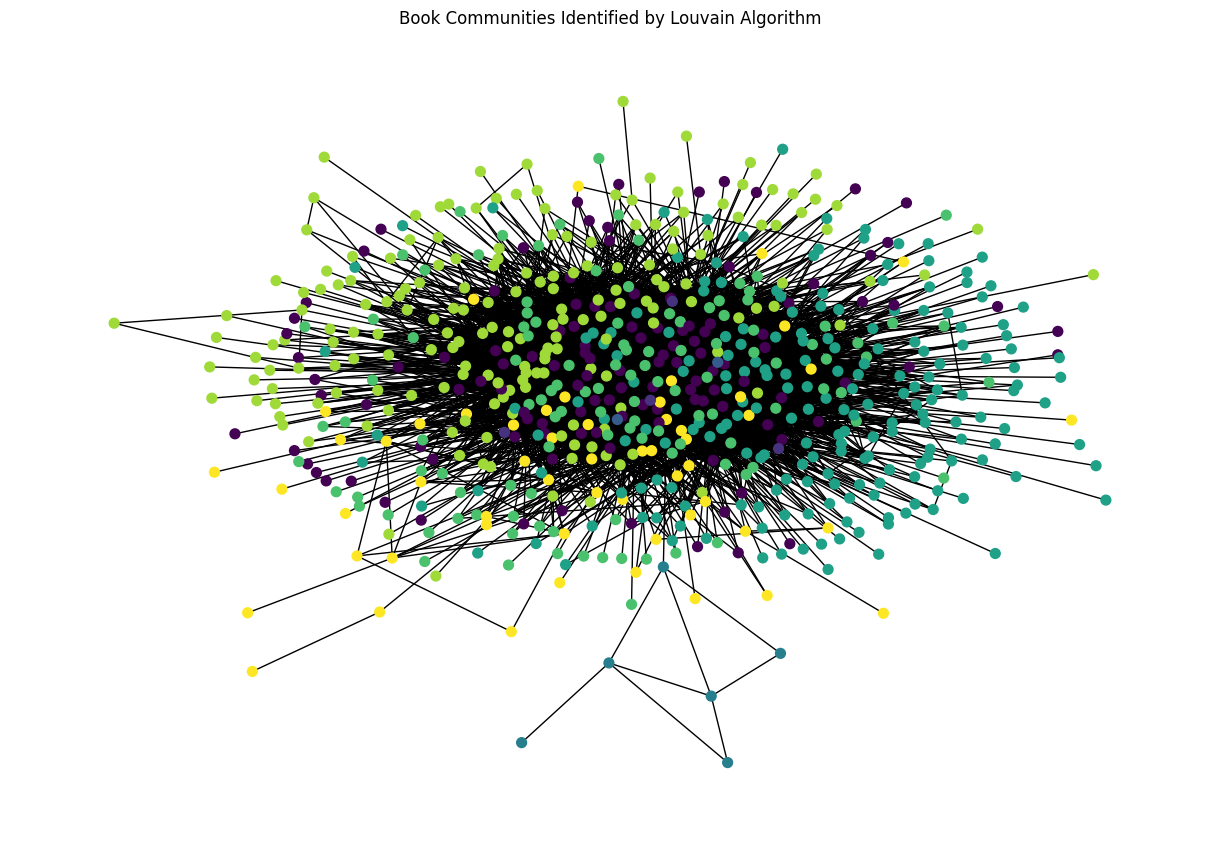

In [ ]:
# Visualize the graph using Kamada-Kawai layout
pos = nx.kamada_kawai_layout(G)
colors = [partition[node] for node in G.nodes]
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_size=50, node_color=colors, cmap=plt.cm.viridis, with_labels=False)

plt.title("Book Communities Identified by Louvain Algorithm")
plt.show()

In [ ]:
# Calculate average similarity between directly or indirectly connected books
average_similarity = nx.average_neighbor_degree(G)
print(average_similarity)

# Identify central books (hubs) that are particularly similar to many other books
central_books = [node for node, degree in G.degree if degree > 50]

{34: 112.32978723404256, 30132: 102.21774193548387, 4672: 58.446308724832214, 18135: 98.36641221374046, 2612: 131.77586206896552, 1989: 115.03896103896103, 71643: 71.76106194690266, 13504: 117.17567567567568, 37684: 132.15873015873015, 7009: 124.34375, 9734: 86.15432098765432, 5107: 59.15120274914089, 2767052: 74.635, 15241: 153.0, 3875: 131.2258064516129, 13499: 126.76470588235294, 6: 67.81512605042016, 5470: 67.4125, 18119: 134.85416666666666, 77204: 67.67206477732793, 5043: 145.47916666666666, 1898: 153.0, 6320: 145.44444444444446, 6310: 131.66666666666666, 5215: 82.52808988764045, 4609: 116.7439024390244, 79060: 147.62857142857143, 14366: 169.4, 14: 122.33802816901408, 830: 139.66666666666666, 2052: 179.4, 50: 229.75, 1202: 135.3125, 3228917: 166.875, 147917: 171.83333333333334, 14497: 142.03125, 3590: 200.0, 16793: 136.0, 960: 164.84375, 45480: 154.22222222222223, 308336: 168.7058823529412, 2550: 142.34, 9739: 171.85714285714286, 816: 101.83333333333333, 14046: 95.82706766917293, 

In [ ]:
# Sort books by average similarity in descending order
sorted_books_by_similarity = sorted(average_similarity.items(), key=lambda x: x[1], reverse=True)

# Print the top 5 books with highest average similarity
top_n_books_similarity = 5  # Choose the number of top books to display
print("\nTop Books by Average Similarity:")
for i, (node, similarity) in enumerate(sorted_books_by_similarity[:top_n_books_similarity]):
    title = G.nodes[node]['title']
    print(f"Book: {title}, Average Similarity: {similarity:.2f}")


Top Books by Average Similarity:
Book: Surely You're Joking, Mr. Feynman!: Adventures of a Curious Character, Average Similarity: 323.00
Book: The Wind in the Willows, Average Similarity: 323.00
Book: Y: The Last Man, Vol. 1: Unmanned (Y: The Last Man, #1), Average Similarity: 323.00
Book: The Power, Average Similarity: 323.00
Book: Diary, Average Similarity: 323.00


In [ ]:
assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree Assortativity Coefficient: {assortativity}")

Degree Assortativity Coefficient: -0.3830175095288611


# **RecSys with Node2Vec**

In [ ]:
# node2vec to learn the node embedding
# generate biased random walks
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=5, workers=1)

Computing transition probabilities:   0%|          | 0/695 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [01:03<00:00,  3.15it/s]


In [ ]:
# train the model on biased rw with a window of 10 (5 nodes before, 5 nodes after):
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
def recommend(book):
    # Look for ID
    id_book_entry = books[books.title == book].id_book
    if not id_book_entry.empty:
        id_book = str(id_book_entry.values[0])

        # Check if id is in vocabulary
        if id_book in model.wv.key_to_index:
            # 10 most similar - word embedding
            similar_books = model.wv.most_similar(id_book, topn=10)

            # list for already included books
            included_titles = []

            for id, similarity in similar_books:
                recommended_title = books[books.id_book == int(id)].title.values[0]

                # Avoid duplicates
                if recommended_title.lower() != book.lower() and recommended_title.lower() not in included_titles:
                    print(f'{recommended_title}: {similarity:.2f}')

                    # Add to list
                    included_titles.append(recommended_title.lower())

                    # To obtain always 5 recommendations
                    if len(included_titles) == 5:
                        break
        else:
            print(f"ID '{id_book}' not found.")
    else:
        print(f"Book not found. Try with another one.")


In [ ]:
print(model.wv.key_to_index)

{'2654': 0, '5107': 1, '4672': 2, '6': 3, '77204': 4, '5': 5, '5470': 6, '505585': 7, '2': 8, '1': 9, '7613': 10, '4981': 11, '71643': 12, '1885': 13, '3': 14, '7608': 15, '2767052': 16, '2956': 17, '890': 18, '2187': 19, '5215': 20, '524': 21, '10210': 22, '4': 23, '4382': 24, '5129': 25, '929': 26, '9734': 27, '3636': 28, '2429135': 29, '3985': 30, '14046': 31, '4142473': 32, '4667024': 33, '18135': 34, '43641': 35, '9712': 36, '1618': 37, '16103': 38, '1934': 39, '30132': 40, '4395': 41, '257971': 42, '1226': 43, '8852': 44, '10819': 45, '5692': 46, '5220': 47, '10127': 48, '9717': 49, '5907': 50, '8844': 51, '6288': 52, '34': 53, '151': 54, '2289': 55, '7717': 56, '1420': 57, '4953': 58, '968': 59, '864': 60, '401608': 61, '128029': 62, '4989': 63, '26973': 64, '3074284': 65, '6334': 66, '14891': 67, '4609': 68, '39988': 69, '4472': 70, '5113': 71, '4588': 72, '5439': 73, '13504': 74, '4422': 75, '395040': 76, '5297': 77, '6149': 78, '19063': 79, '93504': 80, '402129': 81, '6689': 

In [ ]:
books.loc[books['id_book'] == 2, 'title'].values[0]

'Harry Potter and the Order of the Phoenix (Harry Potter, #5)'

In [ ]:
# for each book (node of the graph) we can get the most similar ones
# format -> book: how similar it is
# check results
recommend("Harry Potter and the Sorcerer's Stone (Harry Potter, #1)")

Harry Potter and the Half-Blood Prince (Harry Potter, #6): 0.72
Harry Potter and the Order of the Phoenix (Harry Potter, #5): 0.71
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3): 0.68
Harry Potter and the Goblet of Fire (Harry Potter, #4): 0.67
Harry Potter and the Deathly Hallows (Harry Potter, #7): 0.62


**Exporting the Graph**

In [ ]:
file_path3 = "/content/drive/MyDrive/archive (16)/goodreads2.gexf"

# Export graph GEXF
nx.write_gexf(G, file_path3)